In [1]:
import datetime as dt
import math

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

import sys

sys.path.append("..")
# from tooling.enums import AssetClass, Index, Spot, StrikeSpread
# from tooling.fetch import fetch_option_data, fetch_spot_data
# from tooling.filter import find_atm, option_tool

from fetching_from_local_db.enums import AssetClass, Index, StrikeSpread
from fetching_from_local_db.fetch_from_db import (
    _fetch_batch,
    fetch_data,
    fetch_spot_data,
)

In [2]:
async def get_expiry(f_today):

    if (f_today <= dt.date(2024, 1, 25)) and (f_today >= dt.date(2024, 1, 18)):
        f_expiry = dt.date(2024, 1, 25)
    elif (f_today <= dt.date(2024, 1, 31)) and (f_today >= dt.date(2024, 1, 26)):
        f_expiry = dt.date(2024, 1, 31)
    elif (f_today <= dt.date(2024, 2, 22)) and (f_today >= dt.date(2024, 2, 29)):
        f_expiry = dt.date(2024, 2, 29)
    elif (f_today <= dt.date(2024, 3, 25)) and (f_today >= dt.date(2024, 3, 27)):
        f_expiry = dt.date(2024, 2, 27)
    elif f_today < dt.date(2023, 9, 1):
        days_to_thursday = (3 - f_today.weekday()) % 7
        nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
        f_expiry = nearest_thursday
        if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
            f_expiry = nearest_thursday - dt.timedelta(days=1)
    elif f_today >= dt.date(2023, 9, 1):
        if f_today.day < 24:
            days_to_wednesday = (2 - f_today.weekday()) % 7
            nearest_wednesday = f_today + dt.timedelta(days=days_to_wednesday)
            f_expiry = nearest_wednesday
            if nse.valid_days(
                start_date=nearest_wednesday, end_date=nearest_wednesday
            ).empty:
                f_expiry = nearest_wednesday - dt.timedelta(days=1)
        else:
            days_to_thursday = (3 - f_today.weekday()) % 7
            nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
            f_expiry = nearest_thursday
            if nse.valid_days(
                start_date=nearest_thursday, end_date=nearest_thursday
            ).empty:
                f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_finnifty(f_today):

    days_to_thursday = (1 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_nifty(f_today):

    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


async def get_expiry_midcpnifty(f_today):

    days_to_thursday = (0 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


import datetime as dt


async def get_monthly_expiry_nifty(input_date):
    # Get the last day of the current month
    current_month_last_day = (
        input_date.replace(day=28) + dt.timedelta(days=4)
    ).replace(day=1) - dt.timedelta(days=1)

    # Find the last Thursday of the current month
    last_thursday_current_month = current_month_last_day - dt.timedelta(
        days=(current_month_last_day.weekday() - 3) % 7
    )

    # Check if the current date is less than the last Thursday of the current month
    if input_date < last_thursday_current_month:
        last_thursday = last_thursday_current_month
    else:
        # If the current date has passed the last Thursday, find the last Thursday of the next month
        next_month = (input_date.month % 12) + 1
        next_month_year = input_date.year if next_month > 1 else input_date.year + 1

        # Get the last day of the next month (considering February correctly)
        if next_month == 2:  # February
            if next_month_year % 4 == 0 and (
                next_month_year % 100 != 0 or next_month_year % 400 == 0
            ):
                last_day_of_next_month = 29  # Leap year
            else:
                last_day_of_next_month = 28  # Non-leap year
        else:
            # Calculate the last day of the next month
            last_day_of_next_month = (
                dt.date(next_month_year, next_month, 1) + dt.timedelta(days=31)
            ).replace(day=1) - dt.timedelta(days=1)
            last_day_of_next_month = (
                last_day_of_next_month.day
            )  # Extract the day as an integer

        # Create a date for the last day of the next month
        last_day_of_next_month_date = dt.date(
            next_month_year, next_month, last_day_of_next_month
        )

        # Find the last Thursday of the next month
        last_thursday = last_day_of_next_month_date - dt.timedelta(
            days=(last_day_of_next_month_date.weekday() - 3) % 7
        )

    # Validate if the last Thursday is a trading day
    if nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
        # If it's a holiday, find the previous valid trading day
        last_thursday -= dt.timedelta(days=1)
        while nse.valid_days(start_date=last_thursday, end_date=last_thursday).empty:
            last_thursday -= dt.timedelta(days=1)

    return last_thursday


async def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [3]:
# bnf_pandas = pd.read_csv("../data/bnf_min.csv")
bnf_pandas = pd.read_csv("../data/nifty.csv")
# bnf_pandas = pd.read_csv("../data/fin_min.csv")
# bnf_pandas = pd.read_csv("../data/midcp_min.csv")
# bnf_pandas = pd.read_csv("../data/sensex_min.csv")
# bnf_pandas = pd.read_csv("../data/bankex_min.csv")

In [4]:
# If Stocks Data ...
bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["datetime"])
bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# bnf_pandas

In [5]:
bnf = pl.DataFrame(bnf_pandas)
print(type(bnf))
# bnf

<class 'polars.dataframe.frame.DataFrame'>


In [6]:
bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")
bnf = bnf.with_columns(pl.col("index").alias("datetime"))

In [7]:
# bnf = bnf.rename({"open": "o", "high": "h", "low": "l", "close": "c", "volume": "v"})

In [8]:
def resample(data, timeframe, offset=None):
    agg_list = [
        pl.col("o").first().alias("o"),
        pl.col("h").max().alias("h"),
        pl.col("l").min().alias("l"),
        pl.col("c").last().alias("c"),
    ]
    if timeframe == '10m':
        offset = '5m'
    if "v" in data.columns:
        agg_list.append(pl.col("v").sum().alias("v"))
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(agg_list)
    )


In [9]:
# def generate_signals(df, n=5):
#     import numpy as np
#     import pandas as pd

#     # Ensure required columns are present
#     required_cols = {'o', 'h', 'l', 'c', 'datetime'}
#     if not required_cols.issubset(df.columns):
#         raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
#     # Ensure datetime is in datetime format
#     if not np.issubdtype(df['datetime'].dtype, np.datetime64):
#         df['datetime'] = pd.to_datetime(df['datetime'])
    
#     # Calculate the low of the previous n candles
#     df['Prev_N_Low'] = df['l'].rolling(window=n).min().shift(1)
    
#     # Generate sell signal
#     df['Sell Signal'] = df['c'] < df['Prev_N_Low']
    
#     # Drop intermediate columns if not needed
#     df.drop(columns=['Prev_N_Low'], inplace=True, errors='ignore')
    
#     return df


In [10]:
# USING SMA LOW for ENTRY
def generate_signals(df, st_num=3, ema=5, pct=0.9):
    """
    Calculate signals for reversal selling strategy with SMA-based condition.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with columns 'datetime', 'o', 'h', 'l', 'c', and optionally 'v'.
    st_num (int): Period for short-term SMA and low calculation.
    ema (int): Period for EMA calculation.
    pct (float): Percentage threshold for high price comparison.
    
    Returns:
    pd.DataFrame: DataFrame with additional columns 'Reversal Sell Signal' and tracking indicators.
    """
    # Ensure the DataFrame has the required columns
    required_columns = {'datetime', 'h', 'l', 'c'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Calculate short-term SMA of the lows
    df['SMA_Low'] = df['l'].rolling(window=st_num).mean().shift(1)
    
    # Calculate a very short-term EMA (e.g., 5-period)
    df['EMA_5'] = df['c'].ewm(span=ema, adjust=False).mean()
    
    # Calculate daily high till now
    df['daily_high_till_now'] = df.groupby(df['datetime'].dt.date)['h'].cummax()
    
    # Define Reversal Sell Signal
    df['Sell Signal'] = (
        (df['h'] > (pct * df['daily_high_till_now'].shift(1))) &  # Price is near or above the daily high
        (df['c'] < df['SMA_Low'])  # Close below SMA of the lows
    ).astype(int)
    
    return df


In [11]:
def generate_signals(df, st_num=3, ema=5, pct=0.9):
    """
    Calculate signals for reversal selling strategy.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with columns 'datetime', 'o', 'h', 'l', 'c', and optionally 'v'.
    
    Returns:
    pd.DataFrame: DataFrame with additional columns 'Reversal Sell Signal' and tracking indicators.
    """
    # Ensure the DataFrame has the required columns
    required_columns = {'datetime', 'h', 'l', 'c'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Calculate a 3-period high (short-term high)
    df['short_term_low'] = df['l'].rolling(window=st_num).min().shift(1)

    # Calculate a very short-term EMA (e.g., 5-period)
    df['EMA_5'] = df['c'].ewm(span=ema, adjust=False).mean()
    
    # Calculate daily high till now
    df['daily_high_till_now'] = df.groupby(df['datetime'].dt.date)['h'].cummax()
    
    # Define Reversal Sell Signal
    # df['Sell Signal'] = (
    #     (df['h'] > (pct*df['daily_high_till_now'].shift(1))) &  # Price is near or above the daily high
    #     (df['c'] < df['short_term_low']) &  # Closing below the short-term high (early weakness)
    #     (df['c'] < df['EMA_5'])  # Close below very short-term EMA for confirmation
    # ).astype(int)
    df['Sell Signal'] = (
        (df['h'] > (pct*df['daily_high_till_now'].shift(1))) &  # Price is near or above the daily high
        (df['c'] < df['short_term_low'])).astype(int)
    
    return df


In [12]:
data = bnf_pandas.copy()
# data['datetime'] = pd.to_datetime(data['datetime'].dt.date)
print(data["datetime"].tail())
trading_days_set = set(data["datetime"].dt.date)
# sorted(trading_days_set)

735722   2024-12-13 15:25:00
735723   2024-12-13 15:26:00
735724   2024-12-13 15:27:00
735725   2024-12-13 15:28:00
735726   2024-12-13 15:29:00
Name: datetime, dtype: datetime64[ns]


In [24]:
# GLOBAL VARIABLES

INSTRUMENT = "NIFTY"
INDEX = "nifty"
INDEX_MROUND = 50
# INDEX_MROUND=100

# INSTRUMENT = "NIFTY"
# INDEX = "nifty"
# INDEX_MROUND=50

PORTFOLIO_VALUE = 10_00_000
INDEX_LEV = 8
RPT_CE = 0.02
RPT_PE = 0.02
SLIPPAGE = 0.01
TF = "10m"

# SIGNAL_MA = 20
# NUM_OF_CANDELS = 1
# T_MA=20
# TARGET=100

In [25]:
bnf = resample(bnf, TF)
data = bnf.to_pandas()
data.tail()
# data[['MA','signal_spot']]=MA(data,200)
# data[data['signal_spot']==1].head(50)
# bnf
# data.tail(50)
# data[data['datetime'].dt.date == dt.date(2024, 4, 29)]

,datetime,o,h,l,c
74560,2024-12-13 14:45:00,24738.7500,24747.8500,24705.8500,24740.9500
74561,2024-12-13 14:55:00,24742.3000,24765.4000,24735.9000,24764.5000
74562,2024-12-13 15:05:00,24765.6000,24790.2500,24762.3000,24771.4500
74563,2024-12-13 15:15:00,24772.1500,24792.3000,24761.0500,24785.7500
74564,2024-12-13 15:25:00,24785.5000,24788.3500,24778.8500,24781.3000


In [26]:
async def ce_trade(data, st_high, ema, pct):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    ce_lowest_low = float("inf")
    ce_highest_high = float("-inf")
    entry_rsi = 0

    while current_date < end_date:
        print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_ce_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_ce_sl = False
        previous_ce_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_ce_trade and current_date in trading_days_set:

            ce_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {ce_search_datetime}')

            spot_open = df.loc[df["datetime"] >= ce_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.ceil(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_ce = spot_atm
            # print(f'selected strike CE : {selected_strike_ce}')
            ce_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=7),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_ce,
                asset_class="C",
                expiry=nearest_expiry,
            )
            # print(ce_df)
            if ce_df is not None and not isinstance(ce_df, str):
                # print('new data fetched CE')
                data_ce = True
                ce_df = ce_df.select(["datetime", "o", "h", "l", "c", "v"])
                ce_df = resample(ce_df, TF)
                ce_df_pandas = ce_df.to_pandas()
                ce_df = generate_signals(ce_df_pandas, st_high, ema, pct)
                # ce_df = calculate_signals(ce_df_pandas)
                # print(ce_df.to_string())
            else:
                data_ce = False
                current_date += dt.timedelta(days=1)
                continue

            if data_ce:

                for i in range(0, len(ce_df)):
                    current_candle = ce_df.iloc[i]
                    current_candle_open = ce_df.iloc[i]["o"]
                    current_candle_high = ce_df.iloc[i]["h"]
                    current_candle_low = ce_df.iloc[i]["l"]
                    current_candle_close = ce_df.iloc[i]["c"]

                    previous_candle_low = ce_df.iloc[i - 1]["l"]
                    previous_candle_close = ce_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_ce
                    asset_class = "C"
                    # print(ce_df.iloc[i])

                    signal = ce_df.iloc[i - 1]["Sell Signal"]

                    if ce_df.iloc[i]["datetime"] >= ce_search_datetime:


                        if (
                            not previous_ce_sl_hit
                            and not in_ce_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and ce_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - ce_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - ce_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and ce_df.iloc[i]["datetime"].time() < dt.time(15, 25)
                        ):
                            # print(ce_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {ce_df.iloc[i]["datetime"]}')
                            
                            # today_data = ce_df[ce_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i-1]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = ce_df.iloc[i-1]["datetime"].date()
                            entry_time = ce_df.iloc[i-1]["datetime"].time()
                            # initial_sl = ce_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = ce_df.iloc[i-1]['daily_high_till_now']
                            in_ce_trade = True
                            ce_lowest_low = float("inf")
                            ce_highest_high = float("-inf")
                            # print(f'initial SL : {initial_sl}')
                            # entry_rsi = ce_df.iloc[i-1]['RSI']

                            qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                            # print(f'qty : {qty}')

                        # While in trade, track the highest high and lowest low
                        if in_ce_trade:
                            # Track the highest high
                            ce_highest_high = max(ce_highest_high, current_candle_high)

                            # Track the lowest low
                            ce_lowest_low = min(ce_lowest_low, current_candle_low)

                            # if all(
                            #     ce_df.loc[i - j, "h"] <= ce_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = ce_df.loc[i - fractal_num, "h"]

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(ce_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_ce_trade and current_candle_high > initial_sl:
                            # print(ce_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {ce_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            stop_trading = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = ce_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = ce_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if (
                            in_ce_trade
                            and ce_df.iloc[i]["datetime"].date() == nearest_expiry
                            and ce_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(ce_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {ce_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = ce_df.iloc[i]["datetime"]
                            in_ce_trade = False
                            previous_ce_sl_hit = True
                            is_gap_ce_sl = False
                            points_captured = entry - exit
                            exit_time = ce_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": ce_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": ce_df.iloc[i]["datetime"].year,
                                "Trade Month": ce_df.iloc[i]["datetime"].month,
                                "Highest High": ce_highest_high,  # Add highest high to trade data
                                "Lowest Low": ce_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - ce_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_ce_trade
                            and not previous_ce_sl_hit
                            and ce_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [27]:
async def pe_trade(data, st_high, ema, pct):
    df = data.copy()

    start_date = dt.date(2019, 1, 1)
    end_date = dt.date(2024, 11, 30)

    current_date = start_date

    combined_trades = pd.DataFrame()
    total_trades = pd.DataFrame()
    time_of_day = dt.time(9, 15)
    trade_book = []
    pe_lowest_low = float("inf")
    pe_highest_high = float("-inf")
    entry_rsi = 0

    while current_date < end_date:
        print(current_date)
        entry = 0
        initial_sl = 0
        exit = 0
        in_pe_trade = False
        in_pe_trade = False
        # signal_exist=False

        points_captured = 0
        remark = ""
        trailing_active = False
        tsl = 0
        stop_trading = False
        is_gap_pe_sl = False
        previous_pe_sl_hit = False
        current_date_increament_flag = False
        # tsl_high = 0

        starting_time = dt.time(9, 15)

        ending_time = dt.time(15, 30)

        if not in_pe_trade and current_date in trading_days_set:

            pe_search_datetime = dt.datetime.combine(current_date, time_of_day)
            # print(f'current date : {pe_search_datetime}')

            spot_open = df.loc[df["datetime"] >= pe_search_datetime, "o"].iloc[0]
            # print(f'spot open : {spot_open}')
            # spot_atm = int(round(spot_open / INDEX_MROUND) * INDEX_MROUND)
            spot_atm = int(
                math.floor(spot_open / INDEX_MROUND) * INDEX_MROUND
            )  ##ROUNDS TO NEAREST 500 OTM
            # print(f'spot atm : {spot_atm}')
            # nearest_expiry = await get_expiry(current_date)
            nearest_expiry = await get_expiry_nifty(current_date)
            # if current_date== nearest_expiry:
            #     next_expiry_passing_value = current_date + dt.timedelta(days=1)
            #     nearest_expiry = await get_expiry_nifty( next_expiry_passing_value)
            # print(f'passing date for expry : {current_date}')
            # nearest_expiry = await get_monthly_expiry_nifty(current_date)
            # print(f'nearest expiry{nearest_expiry}')
            selected_strike_pe = spot_atm
            # print(f'selected strike PE : {selected_strike_pe}')
            pe_df = await fetch_data(
                index=INDEX,
                start_date=nearest_expiry - dt.timedelta(days=7),
                start_time=starting_time,
                end_date=nearest_expiry,
                end_time=ending_time,
                strike=selected_strike_pe,
                asset_class="P",
                expiry=nearest_expiry,
            )
            if pe_df is not None and not isinstance(pe_df, str):
                # print('new data fetched PE')
                data_pe = True
                pe_df = pe_df.select(["datetime", "o", "h", "l", "c", "v"])
                pe_df = resample(pe_df, TF)
                pe_df_pandas = pe_df.to_pandas()
                pe_df = generate_signals(pe_df_pandas, st_high, ema, pct)
                # pe_df = calculate_signals(pe_df_pandas)
                # print(pe_df.to_string())
            else:
                data_pe = False
                current_date += dt.timedelta(days=1)
                continue

            if data_pe:

                for i in range(0, len(pe_df)):
                    current_candle = pe_df.iloc[i]
                    current_candle_open = pe_df.iloc[i]["o"]
                    current_candle_high = pe_df.iloc[i]["h"]
                    current_candle_low = pe_df.iloc[i]["l"]
                    current_candle_close = pe_df.iloc[i]["c"]

                    previous_candle_low = pe_df.iloc[i - 1]["l"]
                    previous_candle_close = pe_df.iloc[i - 1]["c"]
                    

                    expiry = nearest_expiry
                    strike = selected_strike_pe
                    asset_class = "P"
                    # print(pe_df.iloc[i])

                    signal = pe_df.iloc[i - 1]["Sell Signal"]

                    if pe_df.iloc[i]["datetime"] >= pe_search_datetime:


                        if (
                            not previous_pe_sl_hit
                            and not in_pe_trade
                            and signal
                            # and current_candle_low < previous_candle_low
                            and pe_df.iloc[i]["datetime"].time() > time_of_day
                            and (
                                (nearest_expiry - pe_df.iloc[i]["datetime"].date()).days
                                >= 0
                                and (
                                    nearest_expiry - pe_df.iloc[i]["datetime"].date()
                                ).days
                                < 8
                            )
                            and pe_df.iloc[i]["datetime"].time() < dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i-1])
                            # print(f'entry found {previous_candle_low}')
                            # print(f'entry datetime {pe_df.iloc[i]["datetime"]}')
                            
                            # today_data = pe_df[pe_df['datetime'].dt.date == current_candle['datetime'].date()]
                            # day_high = today_data.iloc[0 : i]['h'].max()
                            # print(today_data.to_string())
                            
                            entry = previous_candle_close
                            entry_date = pe_df.iloc[i-1]["datetime"].date()
                            entry_time = pe_df.iloc[i-1]["datetime"].time()
                            # initial_sl = pe_df.iloc[i - SL_CANDLES_NUM : i]["h"].max()
                            # initial_sl = day_high
                            initial_sl = pe_df.iloc[i-1]['daily_high_till_now']
                            in_pe_trade = True
                            pe_lowest_low = float("inf")
                            pe_highest_high = float("-inf")
                            # entry_rsi = pe_df.iloc[i-1]['RSI']

                            qty = RPT_PE * PORTFOLIO_VALUE / (initial_sl - entry)
                            if (
                                (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                            ) * 100 > 200:
                                qty = PORTFOLIO_VALUE * INDEX_LEV / strike * 2

                        # While in trade, track the highest high and lowest low
                        if in_pe_trade:
                            # Track the highest high
                            pe_highest_high = max(pe_highest_high, current_candle_high)

                            # Track the lowest low
                            pe_lowest_low = min(pe_lowest_low, current_candle_low)

                            # if all(
                            #     pe_df.loc[i - j, "h"] <= pe_df.loc[i - fractal_num, "h"]
                            #     for j in range(0, ((fractal_num * 2) + 1))
                            # ):
                            #     tsl_high = pe_df.loc[i - fractal_num, "h"]

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].time() == dt.time(9, 15)
                            and current_candle_open > initial_sl
                        ):

                            # print(pe_df.iloc[i])
                            # print(f'GAP sl hit {initial_sl}')
                            # print(f'GAP sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            remark = "Gap SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        if in_pe_trade and current_candle_high > initial_sl:
                            # print(pe_df.iloc[i])
                            # print(f'initial sl hit {initial_sl}')
                            # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                            exit = initial_sl
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            stop_trading = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "SL hit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending initial sl trade')
                            trade_book.append(trade)
                            tsl_high = 0
                            points_captured = 0
                            current_date = pe_df.iloc[i]["datetime"].date()
                            current_date_increament_flag = True
                            time_of_day = pe_df.iloc[i]["datetime"].time()
                            # print(f'current date changed to : {current_date} and time to {time_of_day}')
                            break

                        # if in_pe_trade and (current_candle_close > tsl_high) and (tsl_high > 10):
                        #     # print(pe_df.iloc[i])
                        #     # print(f'initial sl hit {initial_sl}')
                        #     # print(f'initial sl datetime {pe_df.iloc[i]["datetime"]}')
                        #     exit=current_candle_close
                        #     otm_datetime = pe_df.iloc[i]['datetime']
                        #     in_pe_trade=False
                        #     stop_trading=False
                        #     previous_pe_sl_hit=True
                        #     is_gap_pe_sl = False
                        #     points_captured=entry-exit
                        #     exit_time = pe_df.iloc[i]['datetime'].time()
                        #     slippage= SLIPPAGE * (entry+exit)
                        #     pnl=(qty*(points_captured-slippage))
                        #     # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                        #     remark = "TSL hit"
                        #     weekday_int = entry_date.weekday()
                        #     weekday_name = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][weekday_int]
                        #     trade = {
                        #             'date' : entry_date,
                        #             'day' : weekday_name,
                        #             'expiry' : expiry,
                        #             'DTE' : (nearest_expiry-entry_date).days,
                        #             # 'atm' : atm,
                        #             # 'scrip' : index ,
                        #             'strike' : strike,
                        #             'type' : asset_class,
                        #             'Entry Price': entry,
                        #             'Entry Time': entry_time,
                        #             'initial sl' : initial_sl,
                        #             'TSL' : tsl_high,
                        #             # 'OTM Entry' : otm_entry,
                        #             'Exit Price': exit,
                        #             'Exit date' : pe_df.iloc[i]['datetime'].date(),
                        #             'Exit Time': exit_time,
                        #             # 'OTM EXIT ' : otm_exit,
                        #             'Remark' : remark,
                        #             'Points Captured': points_captured,
                        #             'Slippage': slippage,
                        #             # 'OTM cost' : otm_exit-otm_entry,
                        #             'Qty': qty,
                        #             'PnL' : pnl,
                        #             'ROI%': (pnl/ PORTFOLIO_VALUE) * 100,
                        #             'Trade Year': pe_df.iloc[i]['datetime'].year,
                        #             'Trade Month': pe_df.iloc[i]['datetime'].month,
                        #             'Highest High': pe_highest_high,  # Add highest high to trade data
                        #             'Lowest Low': pe_lowest_low ,      # Add lowest low to trade data
                        #             'Max ROI%' : ((qty*(entry-pe_lowest_low))/PORTFOLIO_VALUE)*100,
                        #             'Margin' : ((qty*strike)/(INDEX_LEV*PORTFOLIO_VALUE))*100
                        #               }
                        #     # print('apending initial sl trade')
                        #     trade_book.append(trade)
                        #     tsl_high = 0
                        #     points_captured=0
                        #     current_date = pe_df.iloc[i]['datetime'].date()
                        #     current_date_increament_flag = True
                        #     time_of_day = pe_df.iloc[i]['datetime'].time()
                        #     # print(f'current date changed to : {current_date} and time to {time_of_day}')
                        #     break

                        if (
                            in_pe_trade
                            and pe_df.iloc[i]["datetime"].date() == nearest_expiry
                            and pe_df.iloc[i]['datetime'].time() >= dt.time(15, 20)
                        ):
                            # print(pe_df.iloc[i])
                            # print(f'EOD exit {current_candle_close}')
                            # print(f'EOD datetime {pe_df.iloc[i]["datetime"]}')
                            exit = current_candle_close
                            otm_datetime = pe_df.iloc[i]["datetime"]
                            in_pe_trade = False
                            previous_pe_sl_hit = True
                            is_gap_pe_sl = False
                            points_captured = entry - exit
                            exit_time = pe_df.iloc[i]["datetime"].time()
                            slippage = SLIPPAGE * (entry + exit)
                            pnl = qty * (points_captured - slippage)
                            # pnl=(qty*(points_captured-slippage))-qty*(otm_exit-otm_entry)
                            remark = "EOD exit"
                            weekday_int = entry_date.weekday()
                            weekday_name = [
                                "Monday",
                                "Tuesday",
                                "Wednesday",
                                "Thursday",
                                "Friday",
                                "Saturday",
                                "Sunday",
                            ][weekday_int]
                            trade = {
                                "date": entry_date,
                                "day": weekday_name,
                                "expiry": expiry,
                                "DTE": (nearest_expiry - entry_date).days,
                                # 'atm' : atm,
                                # 'scrip' : index ,
                                "strike": strike,
                                "type": asset_class,
                                "Entry Price": entry,
                                "Entry Time": entry_time,
                                "initial sl": initial_sl,
                                # "TSL": tsl_high,
                                # 'OTM Entry' : otm_entry,
                                "Exit Price": exit,
                                "Exit date": pe_df.iloc[i]["datetime"].date(),
                                "Exit Time": exit_time,
                                'RSI on Entry': entry_rsi,
                                # 'OTM EXIT ' : otm_exit,
                                "Remark": remark,
                                "Points Captured": points_captured,
                                "Slippage": slippage,
                                # 'OTM cost' : otm_exit-otm_entry,
                                "Qty": qty,
                                "PnL": pnl,
                                "ROI%": (pnl / PORTFOLIO_VALUE) * 100,
                                "Trade Year": pe_df.iloc[i]["datetime"].year,
                                "Trade Month": pe_df.iloc[i]["datetime"].month,
                                "Highest High": pe_highest_high,  # Add highest high to trade data
                                "Lowest Low": pe_lowest_low,  # Add lowest low to trade data
                                "Max ROI%": (
                                    (qty * (entry - pe_lowest_low)) / PORTFOLIO_VALUE
                                )
                                * 100,
                                "Margin": (
                                    (qty * strike) / (INDEX_LEV * PORTFOLIO_VALUE)
                                )
                                * 100,
                            }
                            # print('apending EOD trade')
                            trade_book.append(trade)
                            # tsl_high = 0
                            points_captured = 0
                            current_date = nearest_expiry + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            # print(f'current date increased by 1 on expiry : {current_date}')
                            break

                        if (
                            not in_pe_trade
                            and not previous_pe_sl_hit
                            and pe_df.iloc[i]["datetime"].time() > dt.time(15, 00)
                        ):
                            # print('inside exoiry non trade date increment')
                            current_date = current_date + dt.timedelta(days=1)
                            current_date_increament_flag = True
                            time_of_day = dt.time(9, 15)
                            break

        if not current_date_increament_flag:
            current_date = current_date + dt.timedelta(days=1)
            current_date_increament_flag = False

    trade_book_df = pd.DataFrame(trade_book)

    return trade_book_df

In [28]:
async def execute(DF, n, rsi_n, rsi_overbought):
    data = DF.copy()
    tb_ce = await ce_trade(data, n, rsi_n, rsi_overbought)
    tb_pe = await pe_trade(data, n, rsi_n, rsi_overbought)
    tb = pd.concat([tb_ce, tb_pe], ignore_index=True)
    # print(len(tb))
    if len(tb)>0:
        tb = tb.sort_values(by="date")
    return tb

In [29]:
def generate_stats(tb_expiry, ema_window):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe

    # Iterate over each year
    for year in range(2019, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]

        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()

        # Calculate total number of trades
        total_trades = len(year_trades)

        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100

        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()

        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()

        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()

        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f"{ema_window}"

        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]

    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0][
        "ROI%"
    ].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum()
        - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio: stats_df8}

In [38]:
# # short_ma = 4
# # long_ma = 12
# # signal_window = 9
# # ema_window = 25
# n = 4
# rsi_n = 6
# rsi_overbought = 45

tb = await execute(data, 48, 50000, 0.5)

2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-15
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-02-26
2019-02-26
2019-02-27
2019-02-28
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-05
2019-03-05
2019-03-06
2019-03-07
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-16
2019-03-17
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-23
2019-03-24
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-03-30
2019-03-31
2019-04-01
2019-04-02
2019-04-02
2019-04-03
2019-04-05
2019-04-06
2019-04-07
2019-04-08
2019-04-09
2019-04-10
2019-04-11
2019-04-12
2019-04-13

In [34]:
stats = generate_stats(tb, '...')
for x, y in stats.items():
    z = pd.DataFrame(y)
    break

z

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,61.4964,99,59.5960,2.3463,-1.9233,-9.5586,6.4336,...
2020,100.7229,120,59.1667,2.8483,-2.0716,-8.3823,12.0161,...
2021,51.3357,115,52.1739,2.8070,-2.1288,-13.5065,3.8008,...
2022,66.4637,109,57.7982,2.5534,-2.0522,-8.0018,8.3061,...
2023,26.8518,119,50.4202,2.4034,-1.9890,-16.6548,1.6123,...
2024,40.4161,78,53.8462,2.6703,-1.9927,-7.8423,5.1536,...
Overall,347.2866,640,55.4688,2.6093,-2.0316,-16.6548,20.8521,...


In [21]:
tb

,date,day,expiry,DTE,strike,type,Entry Price,Entry Time,initial sl,Exit Price,Exit date,Exit Time,RSI on Entry,Remark,Points Captured,Slippage,Qty,PnL,ROI%,Trade Year,Trade Month,Highest High,Lowest Low,Max ROI%,Margin
0,2019-01-25,Friday,2019-01-31,6,10900,C,86.2000,11:18:00,108.9500,0.0500,2019-01-31,15:21:00,0,EOD exit,86.1500,0.8625,879.1209,74978.0220,7.4978,2019,1,89.5500,0.0500,7.5736,119.7802
600,2019-01-25,Friday,2019-01-31,6,10850,P,43.8000,09:15:00,58.8500,58.8500,2019-01-25,13:36:00,0,SL hit,-15.0500,1.0265,1328.9037,-21364.1196,-2.1364,2019,1,61.0000,37.7500,0.8040,180.2326
602,2019-01-29,Tuesday,2019-01-31,2,10600,P,48.6500,14:54:00,71.6500,0.0500,2019-01-31,15:21:00,0,EOD exit,48.6000,0.4870,869.5652,41837.3913,4.1837,2019,1,54.9000,0.0500,4.2261,115.2174
601,2019-01-29,Tuesday,2019-01-31,2,10650,P,51.3500,12:21:00,78.1000,78.1000,2019-01-29,12:51:00,0,SL hit,-26.7500,1.2945,747.6636,-20967.8505,-2.0968,2019,1,78.3500,50.2500,0.0822,99.5327
1,2019-02-11,Monday,2019-02-14,3,10950,C,28.1000,13:48:00,71.1000,0.0500,2019-02-14,15:27:00,0,EOD exit,28.0500,0.2815,465.1163,12915.5814,1.2916,2019,2,45.5000,0.0500,1.3047,63.6628
603,2019-02-11,Monday,2019-02-14,3,11000,P,121.9000,11:51:00,151.8000,151.8000,2019-02-12,14:45:00,0,SL hit,-29.9000,2.7370,668.8963,-21830.7692,-2.1831,2019,2,155.0000,91.0000,2.0669,91.9732
604,2019-02-14,Thursday,2019-02-14,0,10750,P,7.3500,13:57:00,32.5000,0.5000,2019-02-14,15:21:00,0,EOD exit,6.8500,0.0785,795.2286,5384.8907,0.5385,2019,2,14.4000,0.5000,0.5447,106.8588
2,2019-02-15,Friday,2019-02-21,6,10800,C,46.7000,09:54:00,73.0000,0.0500,2019-02-21,15:21:00,0,EOD exit,46.6500,0.4675,760.4563,35119.7719,3.5120,2019,2,54.7000,0.0500,3.5475,102.6616
605,2019-02-15,Friday,2019-02-21,6,10750,P,117.9000,13:42:00,157.2000,157.2000,2019-02-19,15:12:00,0,SL hit,-39.3000,2.7510,508.9059,-21400.0000,-2.1400,2019,2,158.8500,55.9500,3.1527,68.3842
606,2019-02-20,Wednesday,2019-02-21,1,10650,P,23.7500,12:39:00,59.3500,0.0500,2019-02-21,15:21:00,0,EOD exit,23.7000,0.2380,561.7978,13180.8989,1.3181,2019,2,41.7500,0.0500,1.3315,74.7893


In [22]:
# tb.to_csv('revo_all_dte_tradebook.csv')

In [ ]:
#10min
stats_dictionary = {}
for i in range(12, 49, 3):
    for j in range(20, 71, 10):
        print(f'{i}, {j/100}%')
        tb = await execute(data, i, 5, j/100)
        if len(tb) > 0:
            stats = generate_stats(tb, f'{i}, {j}')
            for x, y in stats.items():
                z = pd.DataFrame(y)
                print(z.to_string())
                stats_dictionary[x] = y

12, 0.2%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     120.5141          172  51.1628                3.2933             -2.0155     -12.8817       9.3554    12, 20
2020     126.5948          210  45.2381                3.7569             -2.0027     -10.9372      11.5747    12, 20
2021      69.4058          199  45.2261                3.2051             -2.0097     -20.3931       3.4034    12, 20
2022      27.2400          218  42.2018                3.5251             -2.3577     -37.5770       0.7249    12, 20
2023      32.6265          199  44.2211                2.8562             -1.9704     -18.6660       1.7479    12, 20
2024      28.4675          150  40.6667                3.3033             -1.9442     -29.4236       0.9675    12, 20
Overall  404.8486         1148  44.7735                3.3314             -2.0623     -37.5770      10.7738    12, 20
12, 0.3%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     120.0988          170  50.5882                3.3651             -2.0155     -15.0228       7.9944    12, 30
2020     125.8629          209  44.9761                3.7891             -2.0027     -10.9372      11.5078    12, 30
2021      69.0417          198  44.9495                3.2370             -2.0097     -20.3931       3.3856    12, 30
2022      27.2400          218  42.2018                3.5251             -2.3577     -40.4956       0.6727    12, 30
2023      31.2612          195  43.0769                2.9759             -1.9704     -22.5644       1.3854    12, 30
2024      27.6308          148  39.8649                3.4011             -1.9442     -28.5703       0.9671    12, 30
Overall  401.1355         1138  44.2882                3.3901             -2.0623     -40.4956       9.9056    12, 30
12, 0.4%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     118.5157          169  50.2959                3.3845             -2.0139     -12.7645       9.2848    12, 40
2020     121.2635          205  44.8780                3.7888             -2.0116     -10.4666      11.5858    12, 40
2021      69.9069          195  45.6410                3.2363             -2.0578     -20.3298       3.4386    12, 40
2022      14.5214          211  40.7583                3.6039             -2.3633     -42.9526       0.3381    12, 40
2023      30.8493          192  42.7083                3.0357             -1.9825     -22.5644       1.3672    12, 40
2024      27.7378          142  38.7324                3.6143             -1.9661     -28.9596       0.9578    12, 40
Overall  382.7947         1114  43.8959                3.4395             -2.0786     -42.9526       8.9120    12, 40
12, 0.5%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     125.7168          163  51.5337                3.4002             -2.0241     -10.8993      11.5343    12, 50
2020     115.9236          197  45.6853                3.7145             -2.0410     -10.9372      10.5991    12, 50
2021      82.1522          187  46.5241                3.3547             -2.0971     -18.1649       4.5226    12, 50
2022      12.6306          203  39.4089                3.8055             -2.3724     -44.2763       0.2853    12, 50
2023      36.3195          184  44.0217                3.0436             -2.0409     -14.7620       2.4603    12, 50
2024      26.8951          137  39.4161                3.5921             -2.0130     -20.1830       1.3326    12, 50
Overall  399.6378         1071  44.4444                3.4805             -2.1128     -44.2763       9.0260    12, 50
12, 0.6%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     106.8339          156  46.7949                3.7547             -2.0152     -12.7917       8.3518    12, 60
2020     104.3199          180  46.1111                3.7162             -2.1044     -12.6349       8.2565    12, 60
2021      76.5581          175  44.5714                3.6135             -2.1165     -18.2316       4.1992    12, 60
2022      22.4913          189  39.6825                3.9810             -2.4218     -39.8995       0.5637    12, 60
2023      28.1513          171  43.2749                3.1188             -2.0891     -15.2433       1.8468    12, 60
2024      20.9898          126  37.3016                3.8744             -2.0393     -16.6557       1.2602    12, 60
Overall  359.3442          997  43.1294                3.6648             -2.1455     -39.8995       9.0062    12, 60
12, 0.7%
        Total ROI Total Trades Win Rate Avg Pro

/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     112.4674          163  53.3742                3.0047             -1.9597     -13.2828       8.4671    15, 20
2020     136.2912          195  48.7179                3.6168             -2.0731     -15.3389       8.8853    15, 20
2021      64.1889          190  47.3684                2.9544             -2.0171     -18.1417       3.5382    15, 20
2022      51.1624          201  45.2736                3.2492             -2.2229     -26.9261       1.9001    15, 20
2023      34.0985          187  45.4545                2.7739             -1.9773     -23.3984       1.4573    15, 20
2024      42.3382          138  43.4783                3.1701             -1.8958     -18.3835       2.3031    15, 20
Overall  440.5465         1074  47.2998                3.1350             -2.0354     -26.9261      16.3613    15, 20
15, 0.3%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     112.0521          161  52.7950                3.0705             -1.9597     -13.2979       8.4263    15, 30
2020     138.7616          193  48.7047                3.6475             -2.0617     -12.1366      11.4333    15, 30
2021      64.2607          188  47.3404                2.9835             -2.0331     -18.1417       3.5422    15, 30
2022      47.6649          198  43.9394                3.3747             -2.2156     -30.5131       1.5621    15, 30
2023      34.1034          184  45.1087                2.8331             -1.9905     -22.7628       1.4982    15, 30
2024      41.6278          136  42.6471                3.2672             -1.8958     -20.2856       2.0521    15, 30
Overall  438.4705         1060  46.7925                3.2009             -2.0375     -30.5131      14.3699    15, 30
15, 0.4%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     106.4596          160  51.8750                3.1009             -1.9599     -13.5784       7.8404    15, 40
2020     134.3821          188  48.9362                3.6406             -2.0891     -12.8160      10.4855    15, 40
2021      64.6668          185  47.5676                3.0135             -2.0672     -15.9135       4.0636    15, 40
2022      33.6615          194  42.7835                3.3810             -2.2249     -30.7008       1.0964    15, 40
2023      33.6915          181  44.7514                2.8901             -2.0041     -19.0640       1.7673    15, 40
2024      41.0742          129  41.0853                3.5275             -1.9195     -13.9826       2.9375    15, 40
Overall  413.9356         1037  46.2874                3.2483             -2.0561     -30.7008      13.4829    15, 40
15, 0.5%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     108.4791          156  51.9231                3.1624             -1.9690      -9.0733      11.9559    15, 50
2020     127.6315          179  49.1620                3.6481             -2.1253     -15.7045       8.1271    15, 50
2021      73.3148          176  47.7273                3.1829             -2.1092     -18.0784       4.0554    15, 50
2022      35.6775          187  42.2460                3.5154             -2.2411     -33.6745       1.0595    15, 50
2023      33.8831          173  44.5087                2.9819             -2.0388     -19.1024       1.7738    15, 50
2024      42.9005          122  40.9836                3.6954             -1.9704     -12.2460       3.5032    15, 50
Overall  421.8864          993  46.2236                3.3478             -2.0876     -33.6745      12.5284    15, 50
15, 0.6%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      83.5633          145  45.5172                3.6232             -1.9692     -18.7227       4.4632    15, 60
2020     125.0223          164  49.3902                3.6649             -2.0703      -9.0212      13.8587    15, 60
2021      62.5679          161  44.7205                3.5155             -2.1410     -16.2786       3.8436    15, 60
2022      46.8114          169  42.6036                3.7226             -2.2806     -29.8615       1.5676    15, 60
2023      11.7490          158  41.1392                3.1428             -2.0702     -22.1294       0.5309    15, 60
2024      34.4715          112  39.2857                3.8955             -2.0137     -11.6803       2.9513    15, 60
Overall  364.1854          909  44.0044                3.5820             -2.0995     -29.8615      12.1958    15, 60
15, 0.7%
        Total ROI Total Trades Win Rate Avg Pro

/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     112.9751          155  55.4839                2.9016             -1.9792      -9.6336      11.7272    18, 20
2020     137.3233          193  48.7047                3.5167             -1.9520      -9.2721      14.8103    18, 20
2021      69.4011          183  49.1803                2.8605             -2.0220     -16.6840       4.1597    18, 20
2022      46.0454          196  45.9184                3.1086             -2.2050     -29.0332       1.5860    18, 20
2023      42.9578          181  46.4088                2.7535             -1.9416     -14.7629       2.9098    18, 20
2024      34.6363          137  43.0657                3.0486             -1.8619     -18.6708       1.8551    18, 20
Overall  443.3391         1045  48.1340                3.0387             -2.0021     -29.0332      15.2701    18, 20
18, 0.3%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     112.5599          153  54.9020                2.9658             -1.9792      -9.6336      11.6841    18, 30
2020     138.4981          191  48.6911                3.5327             -1.9392      -8.7264      15.8711    18, 30
2021      69.4730          181  49.1713                2.8886             -2.0392     -18.8186       3.6917    18, 30
2022      43.0536          193  44.5596                3.2349             -2.1976     -29.8398       1.4428    18, 30
2023      43.9808          176  46.5909                2.7756             -1.9534     -12.6816       3.4681    18, 30
2024      33.7228          132  41.6667                3.2389             -1.8756     -18.8375       1.7902    18, 30
Overall  441.2882         1026  47.6608                3.1057             -2.0063     -29.8398      14.7886    18, 30
18, 0.4%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     104.6078          152  53.2895                3.0269             -1.9799     -13.1143       7.9766    18, 40
2020     133.1320          184  48.3696                3.5913             -1.9631      -8.6258      15.4341    18, 40
2021      68.9169          175  49.1429                2.9678             -2.0934     -18.7554       3.6745    18, 40
2022      28.5545          188  43.0851                3.2683             -2.2073     -32.9530       0.8665    18, 40
2023      43.5689          173  46.2428                2.8319             -1.9676     -14.7629       2.9512    18, 40
2024      35.4468          125  40.8000                3.4562             -1.9029     -17.2168       2.0588    18, 40
Overall  414.2269          997  46.9408                3.1786             -2.0290     -32.9530      12.5702    18, 40
18, 0.5%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     105.5562          145  53.1034                3.1386             -2.0017     -11.3711       9.2829    18, 50
2020     131.5803          173  49.1329                3.6226             -2.0039      -8.7663      15.0098    18, 50
2021      74.2001          167  49.1018                3.1370             -2.1533     -17.5190       4.2354    18, 50
2022      35.9857          181  43.6464                3.3311             -2.2272     -30.3823       1.1844    18, 50
2023      28.5479          167  43.7126                2.9570             -1.9927     -15.4117       1.8523    18, 50
2024      47.1469          117  41.8803                3.6594             -1.9436     -13.2451       3.5596    18, 50
Overall  423.0170          950  46.8421                3.2925             -2.0636     -30.3823      13.9231    18, 50
18, 0.6%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      92.1061          133  48.8722                3.5050             -1.9959     -14.4913       6.3559    18, 60
2020     114.3171          158  49.3671                3.5829             -2.0644     -11.1832      10.2222    18, 60
2021      63.5093          152  46.7105                3.3799             -2.1785     -19.1347       3.3191    18, 60
2022      48.0612          160  44.3750                3.5164             -2.2652     -24.8880       1.9311    18, 60
2023      20.6883          153  43.1373                2.9947             -2.0340     -18.2180       1.1356    18, 60
2024      38.2183          103  40.7767                3.8270             -2.0084     -12.0417       3.1738    18, 60
Overall  376.9003          859  45.7509                3.4486             -2.0996     -24.8880      15.1438    18, 60
18, 0.7%
        Total ROI Total Trades Win Rate Avg Pro

/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     108.0542          151  56.9536                2.7029             -1.9137      -8.7570      12.3392    21, 20
2020     134.5609          187  49.7326                3.3916             -1.9240      -9.0878      14.8067    21, 20
2021      65.0411          179  49.7207                2.7809             -2.0274     -18.7951       3.4605    21, 20
2022      42.7394          191  46.5969                2.9942             -2.1935     -25.4384       1.6801    21, 20
2023      33.6591          179  46.9274                2.6057             -1.9496     -16.5270       2.0366    21, 20
2024      31.2498          132  43.1818                2.9964             -1.8606     -15.6114       2.0017    21, 20
Overall  415.3045         1019  48.8714                2.9147             -1.9889     -25.4384      16.3259    21, 20
21, 0.3%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     107.6390          149  56.3758                2.7623             -1.9137      -8.7720      12.2707    21, 30
2020     133.8073          185  49.7297                3.4064             -1.9310      -9.0878      14.7238    21, 30
2021      65.1129          177  49.7175                2.8084             -2.0452     -17.5580       3.7084    21, 30
2022      40.3362          189  45.5026                3.0871             -2.1860     -25.0457       1.6105    21, 30
2023      34.0540          172  46.5116                2.6820             -1.9620     -15.5493       2.1901    21, 30
2024      29.6609          128  41.4062                3.1926             -1.8606     -15.9199       1.8631    21, 30
Overall  410.6102         1000  48.3000                2.9851             -1.9946     -25.0457      16.3945    21, 30
21, 0.4%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019     102.4360          147  55.1020                2.8248             -1.9147     -14.3957       7.1158    21, 40
2020     127.8625          177  49.1525                3.4931             -1.9559      -9.6665      13.2273    21, 40
2021      64.0937          171  49.7076                2.8794             -2.1006     -18.7319       3.4216    21, 40
2022      21.6312          182  42.8571                3.2035             -2.1947     -30.2379       0.7154    21, 40
2023      34.0904          170  46.4706                2.7083             -1.9765     -15.5493       2.1924    21, 40
2024      32.0749          122  40.9836                3.3604             -1.8881     -13.9862       2.2933    21, 40
Overall  382.1887          969  47.4716                3.0637             -2.0179     -30.2379      12.6394    21, 40
21, 0.5%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      99.9353          136  53.6765                3.0585             -1.9577     -10.0559       9.9380    21, 50
2020     126.4170          165  49.6970                3.5655             -1.9994      -8.7663      14.4208    21, 50
2021      68.0683          159  49.0566                3.1487             -2.1918     -17.5190       3.8854    21, 50
2022      33.2189          174  44.2529                3.2248             -2.2175     -28.2438       1.1761    21, 50
2023      22.0306          164  44.5122                2.7962             -2.0010     -16.5639       1.3300    21, 50
2024      42.1987          114  42.1053                3.5638             -1.9525     -10.4483       4.0388    21, 50
Overall  391.8688          912  47.2588                3.2129             -2.0642     -28.2438      13.8745    21, 50
21, 0.6%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      80.6980          122  48.3607                3.4515             -1.9514     -13.3642       6.0384    21, 60
2020     108.9283          152  50.6579                3.4508             -2.0904     -11.1832       9.7404    21, 60
2021      59.6914          145  46.8966                3.3782             -2.2082     -17.6225       3.3872    21, 60
2022      42.9821          156  44.8718                3.3807             -2.2520     -20.9596       2.0507    21, 60
2023      14.2669          147  44.2177                2.8558             -2.0897     -21.6956       0.6576    21, 60
2024      38.5519          100  41.0000                3.8332             -2.0104     -13.1847       2.9240    21, 60
Overall  345.1186          822  46.2287                3.3645             -2.1117     -21.6956      15.9073    21, 60
21, 0.7%
        Total ROI Total Trades Win Rate Avg Pro

/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      98.0532          147  57.8231                2.5435             -1.9055     -12.7553       7.6873    24, 20
2020     136.6070          183  50.8197                3.3237             -1.9167      -9.0878      15.0318    24, 20
2021      53.0697          178  50.0000                2.6499             -2.0536     -21.0478       2.5214    24, 20
2022      34.8917          187  47.0588                2.8510             -2.1817     -20.1834       1.7287    24, 20
2023      46.5566          172  48.2558                2.5851             -1.8877     -16.4921       2.8230    24, 20
2024      37.5049          127  44.8819                2.9249             -1.8459     -14.6053       2.5679    24, 20
Overall  406.6831          994  49.7988                2.8148             -1.9772     -21.0478      19.3219    24, 20
24, 0.3%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      97.5458          145  57.2414                2.5986             -1.9055     -14.1179       6.9094    24, 30
2020     136.0789          181  50.8287                3.3403             -1.9239      -9.0878      14.9737    24, 30
2021      52.9895          175  49.7143                2.7029             -2.0700     -21.0478       2.5176    24, 30
2022      32.3015          185  45.9459                2.9378             -2.1741     -21.8166       1.4806    24, 30
2023      46.9515          165  47.8788                2.6613             -1.8988     -16.2563       2.8882    24, 30
2024      35.9160          123  43.0894                3.1157             -1.8459     -15.5925       2.3034    24, 30
Overall  401.7833          974  49.1786                2.8878             -1.9827     -21.8166      18.4164    24, 30
24, 0.4%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      93.8985          141  56.0284                2.6859             -1.9079     -10.9731       8.5572    24, 40
2020     134.4637          172  50.5814                3.4674             -1.9671      -9.6665      13.9102    24, 40
2021      52.2925          169  49.7041                2.7693             -2.1215     -22.6643       2.3073    24, 40
2022      17.7736          178  43.2584                3.0943             -2.1830     -24.9561       0.7122    24, 40
2023      40.6602          163  46.0123                2.7648             -1.8944     -19.7213       2.0617    24, 40
2024      40.9297          118  42.3729                3.3714             -1.8771     -15.2973       2.6756    24, 40
Overall  380.0182          941  48.0340                3.0103             -2.0054     -24.9561      15.2275    24, 40
24, 0.5%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      94.5407          128  55.4688                2.8973             -1.9503     -12.3855       7.6332    24, 50
2020     123.5746          159  50.9434                3.4651             -2.0141      -8.7663      14.0966    24, 50
2021      54.9607          155  47.7419                3.1149             -2.1672     -21.0982       2.6050    24, 50
2022      26.6733          170  44.1176                3.1377             -2.1964     -23.3591       1.1419    24, 50
2023      31.6646          157  45.2229                2.7980             -1.9418     -21.3484       1.4832    24, 50
2024      46.4876          110  43.6364                3.4801             -1.9444      -9.7672       4.7596    24, 50
Overall  377.9015          879  47.7816                3.1379             -2.0480     -23.3591      16.1779    24, 50
24, 0.6%


/tmp/ipykernel_20487/4246149471.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  qty = RPT_CE * PORTFOLIO_VALUE / (initial_sl - entry)


        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio Variation
2019      75.9639          115  50.4348                3.2139             -1.9375     -16.2748       4.6676    24, 60
2020     105.1533          147  51.7007                3.3360             -2.0899      -8.7663      11.9952    24, 60
2021      42.7572          141  44.6809                3.3893             -2.1893     -23.6787       1.8057    24, 60
2022      29.8647          151  43.7086                3.3191             -2.2258     -17.3984       1.7165    24, 60
2023      23.0739          138  44.2029                2.9359             -2.0262     -21.8619       1.0554    24, 60
2024      42.2806           97  42.2680                3.7720             -2.0066     -10.4557       4.0438    24, 60
Overall  319.0936          789  46.2611                3.3048             -2.0924     -23.6787      13.4760    24, 60
24, 0.7%
        Total ROI Total Trades Win Rate Avg Pro

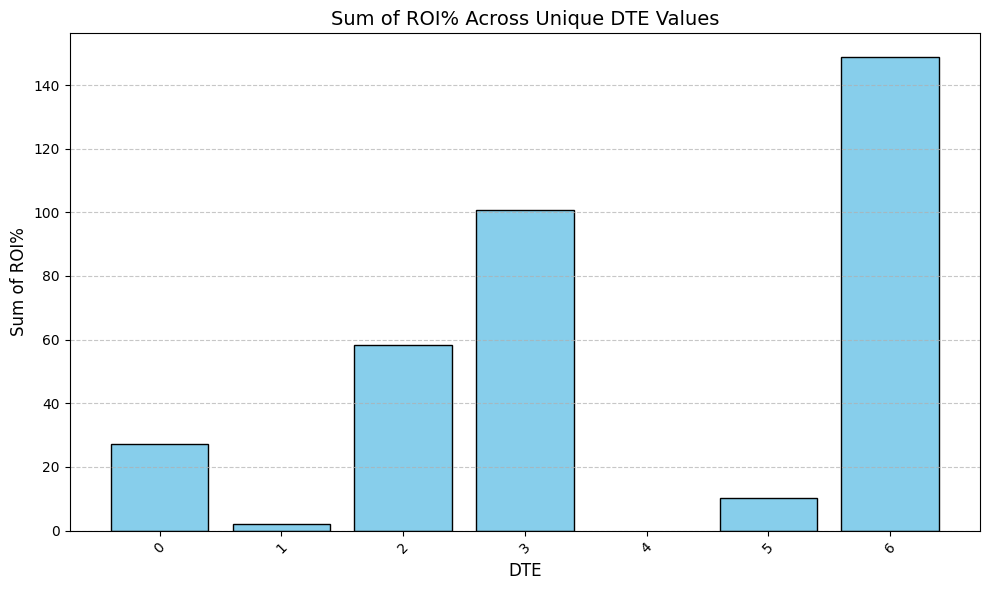

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sum_roi_by_dte(tb):
    """
    Plots the sum of ROI% across all unique DTE values.

    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    """
    # Ensure the DataFrame contains the required columns
    required_columns = {'DTE', 'ROI%'}
    if not required_columns.issubset(tb.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Group by DTE and calculate the sum of ROI%
    result = tb.groupby('DTE', as_index=False)['ROI%'].sum()
    result.rename(columns={'ROI%': 'Sum_ROI%'}, inplace=True)

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(result['DTE'], result['Sum_ROI%'], color='skyblue', edgecolor='black')
    
    # Add labels and title
    plt.title('Sum of ROI% Across Unique DTE Values', fontsize=14)
    plt.xlabel('DTE', fontsize=12)
    plt.ylabel('Sum of ROI%', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# tb = pd.DataFrame({'DTE': [...], 'ROI%': [...]})  # Replace with your actual DataFrame
plot_sum_roi_by_dte(tb)


In [36]:
def calculate_max_dd(tb):
    """
    Calculates the maximum drawdown for each group of 'DTE'.
    
    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    
    Returns:
    pd.Series: Maximum drawdown for each unique DTE.
    """
    # Calculate cumulative sum of ROI%
    cumulative_returns = tb["ROI%"].cumsum()
    
    # Calculate maximum drawdown
    max_drawdown = (cumulative_returns - cumulative_returns.cummax()).min()
    
    return max_drawdown



Resulting DataFrame:
   DTE  Sum_ROI%  Max_DD%  ROI/DD_Ratio
0    0   27.2200   8.2100        3.3100
1    1    1.9300  29.5600        0.0700
2    2   58.3800  12.8300        4.5500
3    3  100.7700  13.3000        7.5700
4    5   10.1700   9.5600        1.0600
5    6  148.8200  21.1300        7.0400


/tmp/ipykernel_59492/3694656327.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dd_result = tb.groupby('DTE').apply(calculate_max_dd).reset_index()


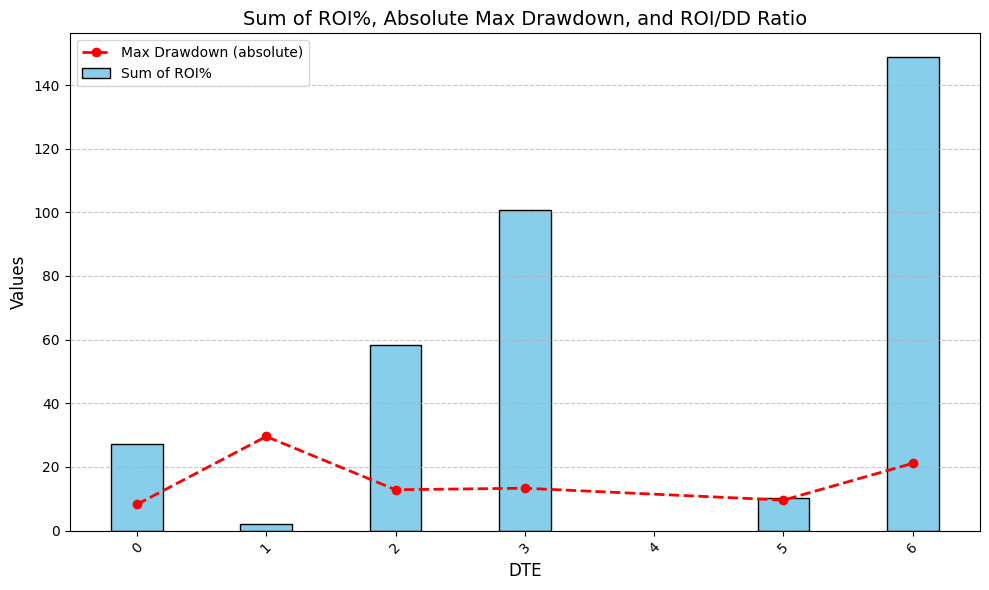

In [37]:
def plot_sum_roi_and_max_dd_by_dte(tb):
    """
    Plots the sum of ROI% and Absolute Max Drawdown (Max DD) across all unique DTE values
    using a single Y-axis, and prints the resulting DataFrame.

    Parameters:
    tb (pd.DataFrame): Input DataFrame with 'DTE' and 'ROI%' columns.
    """
    # Ensure the DataFrame contains the required columns
    required_columns = {'DTE', 'ROI%'}
    if not required_columns.issubset(tb.columns):
        raise ValueError(f"Input DataFrame must contain columns: {required_columns}")
    
    # Group by DTE and calculate the sum of ROI%
    roi_result = tb.groupby('DTE', as_index=False)['ROI%'].sum()
    roi_result.rename(columns={'ROI%': 'Sum_ROI%'}, inplace=True)

    # Group by DTE and calculate Max DD (in absolute terms)
    dd_result = tb.groupby('DTE').apply(calculate_max_dd).reset_index()
    dd_result.rename(columns={0: 'Max_DD%'}, inplace=True)
    dd_result['Max_DD%'] = dd_result['Max_DD%'].abs()

    # Merge the sum of ROI% and Max DD data
    result = pd.merge(roi_result, dd_result, on='DTE')

    # Add ROI% / Max DD ratio
    result['ROI/DD_Ratio'] = result.apply(
        lambda row: row['Sum_ROI%'] / row['Max_DD%'] if row['Max_DD%'] != 0 else float('inf'), axis=1
    )

    # Format values
    result['Sum_ROI%'] = result['Sum_ROI%'].round(2)
    result['Max_DD%'] = result['Max_DD%'].round(2)
    result['ROI/DD_Ratio'] = result['ROI/DD_Ratio'].round(2)

    # Print the DataFrame
    print("\nResulting DataFrame:")
    print(result)

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot Sum of ROI%
    ax.bar(result['DTE'], result['Sum_ROI%'], color='skyblue', edgecolor='black', label='Sum of ROI%', width=0.4, align='center')
    
    # Overlay Max DD (absolute values) on the same axis
    ax.plot(result['DTE'], result['Max_DD%'], color='red', marker='o', label='Max Drawdown (absolute)', linestyle='--', linewidth=2)

    ax.set_xlabel('DTE', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    # Title, legend, and grid
    plt.title('Sum of ROI%, Absolute Max Drawdown, and ROI/DD Ratio', fontsize=14)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    fig.tight_layout()
    plt.show()

plot_sum_roi_and_max_dd_by_dte(tb)
